# Previsão de demanda energética

Previsão de 3 horas na frente utilizando apenas uma rede.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import seaborn as sb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

C:\Users\Pedro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Carregar dataset residencial

In [2]:
casas = {}
for i, filePath in enumerate(sorted(glob.glob('Residencia/*.csv'))):
    casas[i] = pd.read_csv(filePath).filter(['date', 'activeEnergy', 'cepa', 'cepb', 'cepc'])
    #casas[i] = casas[i].dropna(axis = 'columns', how = 'all')
    casas[i]['date'] = pd.to_datetime(casas[i]['date'], yearfirst=True, dayfirst= True, errors = 'coerce')
    casas[i]['weekDay'] = casas[i]['date'].dt.weekday
    casas[i]['hours'] = casas[i]['date'].dt.hour
    casas[i]['EnergyNextHour'] = casas[i]['activeEnergy'].shift(-1)
    casas[i]['EnergyNext2Hours'] = casas[i]['activeEnergy'].shift(-2)
    casas[i].drop(casas[i].index[-3:], inplace = True)
    #casas[i].dropna(axis = 0, how = 'any', inplace = True)
    
    #casas[i] = casas[i][casas[i]['activeEnergy'] < 4*casas[i]['activeEnergy'].std()]

In [3]:
a = 2

In [4]:
print(pd.isnull(casas[a]).any())
#df.loc[df['column_name'] == some_value]

casas[a].head()

date                False
activeEnergy        False
cepa                False
cepb                False
cepc                False
weekDay             False
hours               False
EnergyNextHour      False
EnergyNext2Hours    False
dtype: bool


,date,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
0,2017-03-01 00:00:00,1408,192,548,668,2,0,1316.0,1297.0
1,2017-03-01 01:00:00,1316,184,512,620,2,1,1297.0,1278.0
2,2017-03-01 02:00:00,1297,171,509,617,2,2,1278.0,1279.0
3,2017-03-01 03:00:00,1278,174,499,605,2,3,1279.0,1239.0
4,2017-03-01 04:00:00,1279,187,492,600,2,4,1239.0,1255.0


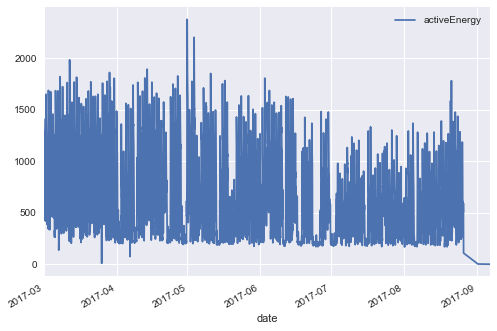

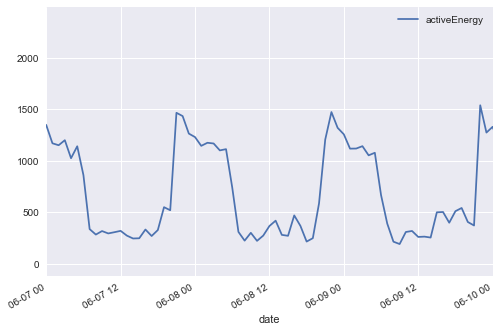

In [5]:
casas[a].plot(x = 'date', y = ['activeEnergy'])#, xlim = ['2017-03-01 00:00:00', ['2017-03-02 00:00:00']])
plt.show()
casas[a].plot(x = 'date', y = ['activeEnergy'], xlim = ['2017-06-07 00:00:00', ['2017-06-10 00:00:00']])
plt.show()

## Truncar os dados

In [6]:
train_set = casas[a][casas[a]['date'] < '2017-08-15 00:00:00']
test_set = casas[a][casas[a]['date'] > '2017-08-15 00:00:00']#.reset_index()

## Retirar tendência

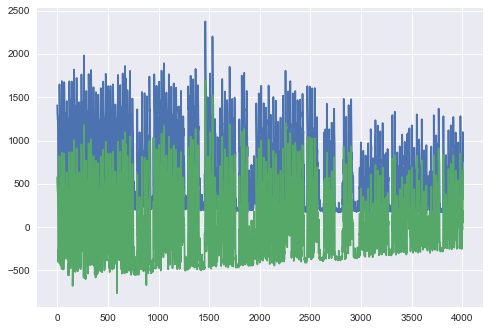

In [7]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
#print(train_set.index.shape, train_set['activeEnergy'].shape)
linearReg.fit(train_set.index[:, np.newaxis], train_set['activeEnergy'])
train_set_without_tendency = train_set['activeEnergy'] - linearReg.predict(train_set.index[:, np.newaxis])
plt.plot(train_set['activeEnergy'])
plt.plot(train_set_without_tendency)
plt.show()

In [8]:
F = train_set.set_index('date')
#print(F.index.freq)
s = sm.tsa.seasonal_decompose(F.activeEnergy)

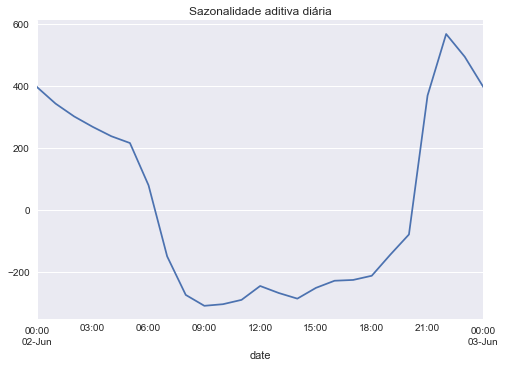

In [9]:
s.seasonal.plot(xlim = ['2017-06-02', '2017-06-03'])
plt.title('Sazonalidade aditiva diária')
plt.show()

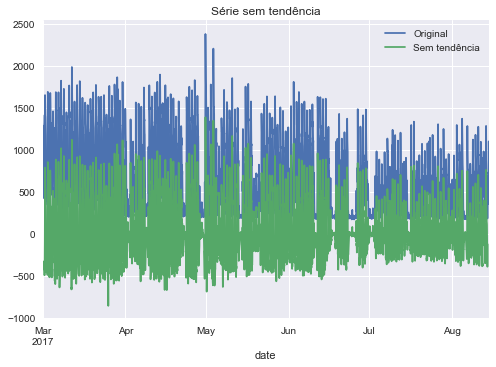

In [10]:
train_set_without_tendency = train_set.set_index('date')['activeEnergy'] - s.trend
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_tendency.plot()
plt.title('Série sem tendência')
plt.legend(['Original', 'Sem tendência'])
plt.show()

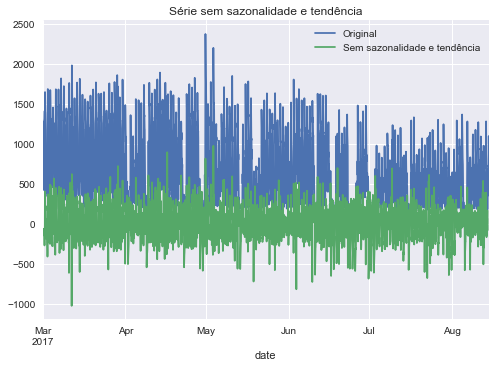

In [11]:
train_set_without_season = train_set_without_tendency - s.seasonal
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_season.plot()
plt.legend(['Original', 'Sem sazonalidade e tendência'])
plt.title('Série sem sazonalidade e tendência')
plt.show()


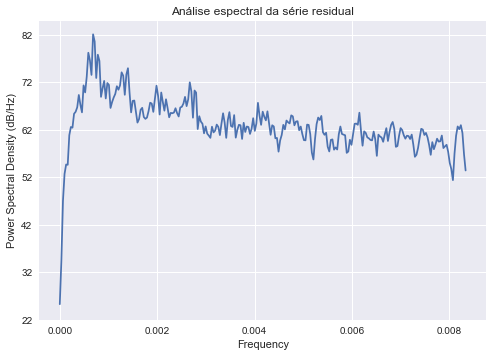

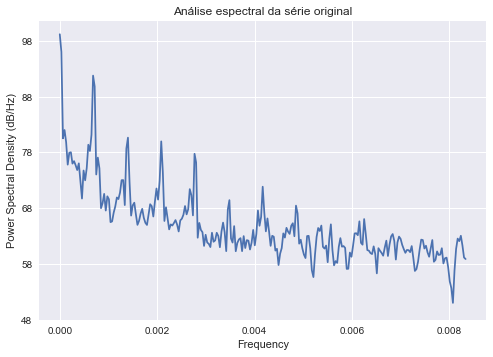

In [12]:
plt.psd(s.resid.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série residual')
plt.show()
plt.psd(F.activeEnergy.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série original')
plt.show()

In [13]:
train_set.set_index('date', inplace = True)
train_set['ResidualSeries'] = s.resid
train_set['SeasonalSeries'] = s.seasonal
train_set['TrendSeries'] = s.trend
train_set.dropna(axis = 0, how = 'any', inplace = True)
train_set.head()

C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-03-01 12:00:00,513,273,33,207,2,12,575.0,483.0,-144.006249,-245.827084,902.833333
2017-03-01 13:00:00,575,335,40,200,2,13,483.0,550.0,-61.558834,-268.503666,905.062500
2017-03-01 14:00:00,483,307,38,138,2,14,550.0,446.0,-139.123970,-286.688530,908.812500
2017-03-01 15:00:00,550,301,8,241,2,15,446.0,418.0,-110.017670,-251.898997,911.916667
2017-03-01 16:00:00,446,294,5,147,2,16,418.0,420.0,-239.082931,-228.896236,913.979167


In [14]:
test_set.set_index('date', inplace = True)
test_set = test_set[:'2017-08-26']
print(test_set.index.freq)
test_set.tail()

None


,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
date,,,,,,,,
2017-08-26 06:00:00,537,159,158,220,5,6,505.0,591.0
2017-08-26 07:00:00,505,142,101,262,5,7,591.0,430.0
2017-08-26 08:00:00,591,298,40,253,5,8,430.0,108.0
2017-08-26 09:00:00,430,261,-1,170,5,9,108.0,2.0
2017-08-26 10:00:00,108,82,6,20,5,10,2.0,0.0


In [15]:
#test_set.set_index('date', inplace = True)
F = test_set.activeEnergy
sTest = sm.tsa.seasonal_decompose(F, freq = 24)
test_set['ResidualSeries'] = sTest.resid
test_set['SeasonalSeries'] = sTest.seasonal
test_set['TrendSeries'] = sTest.trend
test_set.dropna(axis = 0, how = 'any', inplace = True)
test_set.head()

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-08-15 13:00:00,228,146,24,58,1,13,225.0,435.0,74.418868,-350.439702,504.020833
2017-08-15 14:00:00,225,182,10,33,1,14,435.0,594.0,75.894247,-357.435914,506.541667
2017-08-15 15:00:00,435,348,37,50,1,15,594.0,259.0,132.005990,-208.443490,511.437500
2017-08-15 16:00:00,594,371,44,179,1,16,259.0,259.0,302.038187,-222.559020,514.520833
2017-08-15 17:00:00,259,207,10,42,1,17,259.0,297.0,-42.637950,-212.028717,513.666667


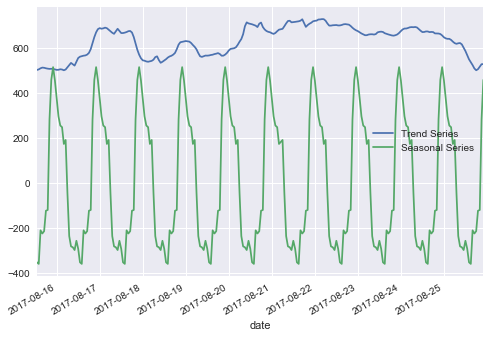

In [16]:
test_set.TrendSeries.plot()
test_set.SeasonalSeries.plot()
plt.legend(['Trend Series', 'Seasonal Series'])
plt.show()

## Pré processamento dos dados

In [17]:
matrix =  casas[a].as_matrix(columns = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 
                                        'hours', 'EnergyNextHour', 'EnergyNext2Hours']).T
print(matrix.shape)
correlationCoef = np.corrcoef(matrix[:,3:])

(8, 4311)


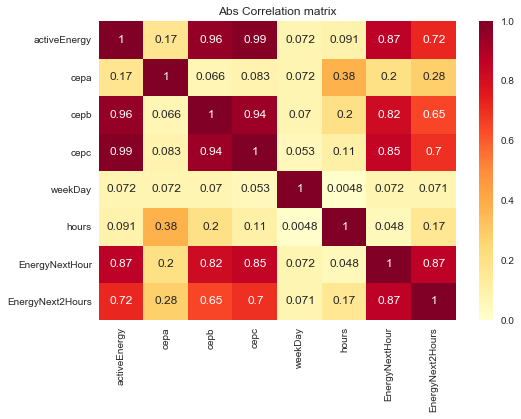

In [18]:
sb.heatmap(np.abs(correlationCoef),
           annot=True, cmap = 'YlOrRd', vmin = 0, vmax =  1,
          xticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'],
          yticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'])
plt.title('Abs Correlation matrix')
plt.show()

## Regressão com Multilayer Perceptron

In [19]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


Além do look_back, o create_dataset no Teste2 adiciona a hora e a data dos dados

In [20]:
def create_dataset(dataset, look_back=1, look_forward = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        b = dataset[i + look_back:i + look_back + look_forward]
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

In [21]:
train_set.shape
look_forward = 3
look_back = 6
#create_dataset(train_series, look_back = 6)

In [22]:
#len(train_set['ResidualSeries'].values)
train_values = train_set['ResidualSeries'].values
train_mean = train_set['ResidualSeries'].mean()
train_std = train_set['ResidualSeries'].std()
train_values -= train_mean
train_values /= train_std


test_values = test_set['ResidualSeries'].values
test_mean = test_set['ResidualSeries'].mean()
test_std = test_set['ResidualSeries'].std()
test_values -= test_mean
test_values /= test_std

x, y = create_dataset(train_values, look_back = look_back, look_forward = look_forward)
testx, testy = create_dataset(test_values, look_back = look_back, look_forward = look_forward)
print(y[-10:], '\n',train_values[-10:])
print(y.shape, x.shape)

[[-0.47194684 -0.69787596 -0.51297503]
 [-0.69787596 -0.51297503 -0.80130554]
 [-0.51297503 -0.80130554 -0.57956011]
 [-0.80130554 -0.57956011 -0.63741353]
 [-0.57956011 -0.63741353 -0.52094075]
 [-0.63741353 -0.52094075 -0.53487956]
 [-0.52094075 -0.53487956 -0.43959544]
 [-0.53487956 -0.43959544  0.32782381]
 [-0.43959544  0.32782381 -0.35617788]
 [ 0.32782381 -0.35617788 -0.40000082]] 
 [-0.57956011 -0.63741353 -0.52094075 -0.53487956 -0.43959544  0.32782381
 -0.35617788 -0.40000082  0.67262302  0.79243516]
(3974, 3) (3974, 6)


In [23]:
model = Sequential()
model.add(Dense(32, input_dim = look_back, activation = 'tanh'))
model.add(Dense(look_forward))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [24]:
history = model.fit(x, y, epochs = 500, validation_split = 0.2, batch_size = 41, verbose =  2)

Train on 3179 samples, validate on 795 samples
Epoch 1/500
0s - loss: 0.8944 - val_loss: 0.6002
Epoch 2/500
0s - loss: 0.7707 - val_loss: 0.5749
Epoch 3/500
0s - loss: 0.7482 - val_loss: 0.5683
Epoch 4/500
0s - loss: 0.7402 - val_loss: 0.5676
Epoch 5/500
0s - loss: 0.7363 - val_loss: 0.5661
Epoch 6/500
0s - loss: 0.7346 - val_loss: 0.5647
Epoch 7/500
0s - loss: 0.7321 - val_loss: 0.5632
Epoch 8/500
0s - loss: 0.7298 - val_loss: 0.5659
Epoch 9/500
0s - loss: 0.7276 - val_loss: 0.5646
Epoch 10/500
0s - loss: 0.7265 - val_loss: 0.5690
Epoch 11/500
0s - loss: 0.7245 - val_loss: 0.5603
Epoch 12/500
0s - loss: 0.7236 - val_loss: 0.5638
Epoch 13/500
0s - loss: 0.7213 - val_loss: 0.5609
Epoch 14/500
0s - loss: 0.7201 - val_loss: 0.5584
Epoch 15/500
0s - loss: 0.7194 - val_loss: 0.5566
Epoch 16/500
0s - loss: 0.7181 - val_loss: 0.5551
Epoch 17/500
0s - loss: 0.7167 - val_loss: 0.5569
Epoch 18/500
0s - loss: 0.7147 - val_loss: 0.5573
Epoch 19/500
0s - loss: 0.7144 - val_loss: 0.5577
Epoch 20/500

0s - loss: 0.6776 - val_loss: 0.5519
Epoch 166/500
0s - loss: 0.6768 - val_loss: 0.5653
Epoch 167/500
0s - loss: 0.6786 - val_loss: 0.5477
Epoch 168/500
0s - loss: 0.6774 - val_loss: 0.5515
Epoch 169/500
0s - loss: 0.6767 - val_loss: 0.5463
Epoch 170/500
0s - loss: 0.6764 - val_loss: 0.5494
Epoch 171/500
0s - loss: 0.6765 - val_loss: 0.5507
Epoch 172/500
0s - loss: 0.6759 - val_loss: 0.5448
Epoch 173/500
0s - loss: 0.6767 - val_loss: 0.5469
Epoch 174/500
0s - loss: 0.6775 - val_loss: 0.5492
Epoch 175/500
0s - loss: 0.6760 - val_loss: 0.5512
Epoch 176/500
0s - loss: 0.6761 - val_loss: 0.5524
Epoch 177/500
0s - loss: 0.6757 - val_loss: 0.5530
Epoch 178/500
0s - loss: 0.6760 - val_loss: 0.5487
Epoch 179/500
0s - loss: 0.6747 - val_loss: 0.5496
Epoch 180/500
0s - loss: 0.6761 - val_loss: 0.5470
Epoch 181/500
0s - loss: 0.6757 - val_loss: 0.5525
Epoch 182/500
0s - loss: 0.6753 - val_loss: 0.5524
Epoch 183/500
0s - loss: 0.6761 - val_loss: 0.5477
Epoch 184/500
0s - loss: 0.6747 - val_loss: 0

0s - loss: 0.6620 - val_loss: 0.5513
Epoch 328/500
0s - loss: 0.6615 - val_loss: 0.5517
Epoch 329/500
0s - loss: 0.6619 - val_loss: 0.5525
Epoch 330/500
0s - loss: 0.6615 - val_loss: 0.5548
Epoch 331/500
0s - loss: 0.6603 - val_loss: 0.5513
Epoch 332/500
0s - loss: 0.6629 - val_loss: 0.5512
Epoch 333/500
0s - loss: 0.6614 - val_loss: 0.5557
Epoch 334/500
0s - loss: 0.6610 - val_loss: 0.5523
Epoch 335/500
0s - loss: 0.6611 - val_loss: 0.5534
Epoch 336/500
0s - loss: 0.6611 - val_loss: 0.5557
Epoch 337/500
0s - loss: 0.6617 - val_loss: 0.5524
Epoch 338/500
0s - loss: 0.6618 - val_loss: 0.5500
Epoch 339/500
0s - loss: 0.6603 - val_loss: 0.5498
Epoch 340/500
0s - loss: 0.6612 - val_loss: 0.5493
Epoch 341/500
0s - loss: 0.6610 - val_loss: 0.5637
Epoch 342/500
0s - loss: 0.6620 - val_loss: 0.5502
Epoch 343/500
0s - loss: 0.6593 - val_loss: 0.5535
Epoch 344/500
0s - loss: 0.6610 - val_loss: 0.5482
Epoch 345/500
0s - loss: 0.6613 - val_loss: 0.5509
Epoch 346/500
0s - loss: 0.6598 - val_loss: 0

0s - loss: 0.6531 - val_loss: 0.5549
Epoch 490/500
0s - loss: 0.6544 - val_loss: 0.5556
Epoch 491/500
0s - loss: 0.6530 - val_loss: 0.5571
Epoch 492/500
0s - loss: 0.6538 - val_loss: 0.5561
Epoch 493/500
0s - loss: 0.6549 - val_loss: 0.5582
Epoch 494/500
0s - loss: 0.6531 - val_loss: 0.5649
Epoch 495/500
0s - loss: 0.6542 - val_loss: 0.5547
Epoch 496/500
0s - loss: 0.6531 - val_loss: 0.5597
Epoch 497/500
0s - loss: 0.6529 - val_loss: 0.5559
Epoch 498/500
0s - loss: 0.6539 - val_loss: 0.5565
Epoch 499/500
0s - loss: 0.6523 - val_loss: 0.5574
Epoch 500/500
0s - loss: 0.6528 - val_loss: 0.5563


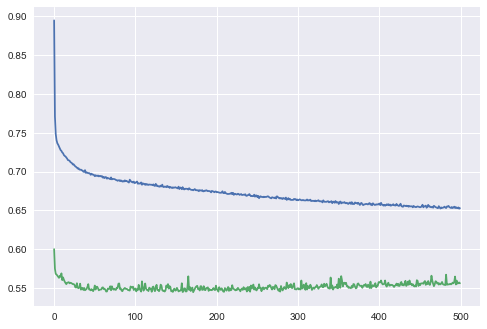

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [26]:
predictedTest = model.predict(testx)
ploting = predictedTest*test_std + test_mean 
print(test_set['SeasonalSeries'].values.shape)
ploting = ploting[:,1] + test_set['SeasonalSeries'].values[look_back-1:-look_forward-2] +test_set['TrendSeries'].values[look_back-1:-look_forward-2]
print(test_std, test_mean)
print(test_set['SeasonalSeries'].values.shape, test_set['TrendSeries'].values.shape)
print(predictedTest.shape, ploting.shape)


(249,)
178.1663610617089 3.8393229166667258
(249,) (249,)
(239, 3) (239,)


In [27]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error for residual series: %.4f'%mean_absolute_error(predictedTest, testy))
print('Mean absolute error for complete series: %.4f'%mean_absolute_error(ploting, test_set['activeEnergy'][look_back-1:-look_forward-2].values))

Mean absolute error for residual series: 0.7014
Mean absolute error for complete series: 95.9339


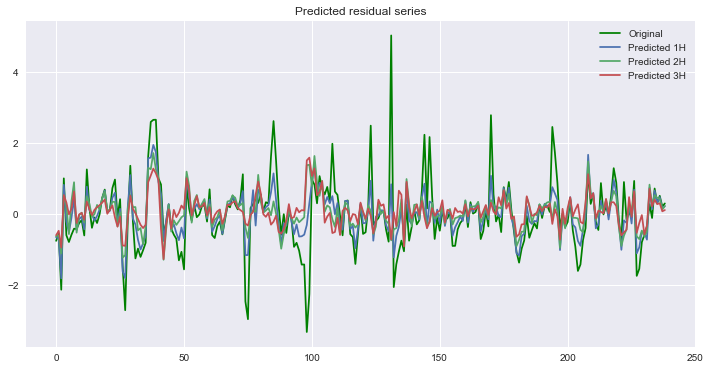

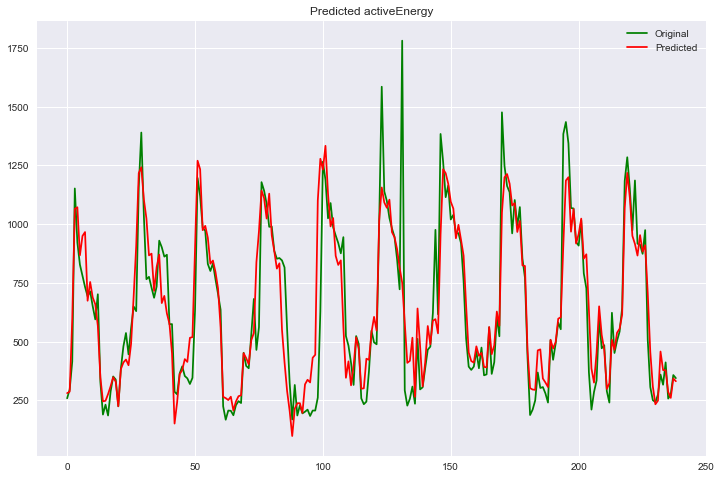

In [28]:
plt.figure(figsize = (12,6))
plt.title('Predicted residual series')
plt.plot(test_set['ResidualSeries'][look_back-1:-look_forward-2].values, 'g')
plt.plot(predictedTest)
plt.legend(['Original', 'Predicted 1H', 'Predicted 2H', 'Predicted 3H'])
plt.show()

plt.figure(figsize = (12,8))
plt.title('Predicted activeEnergy')
plt.plot(test_set['activeEnergy'][look_back-1:-look_forward-2].values, 'g')
plt.plot(ploting, 'r')
plt.legend(['Original', 'Predicted'])

plt.show()

